# Figure 1: Study map

Map of the study area in south-east Queensland and north-east New South Wales. The study area (blue) encompasses the Queensland state capital (Brisbane) as well as several smaller urban areas indicated in the map by points sized according to their population (Australian Bureau of Statistics 2021). The location of the Mount Stapylton radar is also highlighted (red triangle) along with its 135 km range ring highlighted (pink).

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(sf)
  library(ozmaps, lib.loc = additional_package_lib)
  library(paletteer)
  library(ggspatial, lib.loc = additional_package_lib)
})

## Make the plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


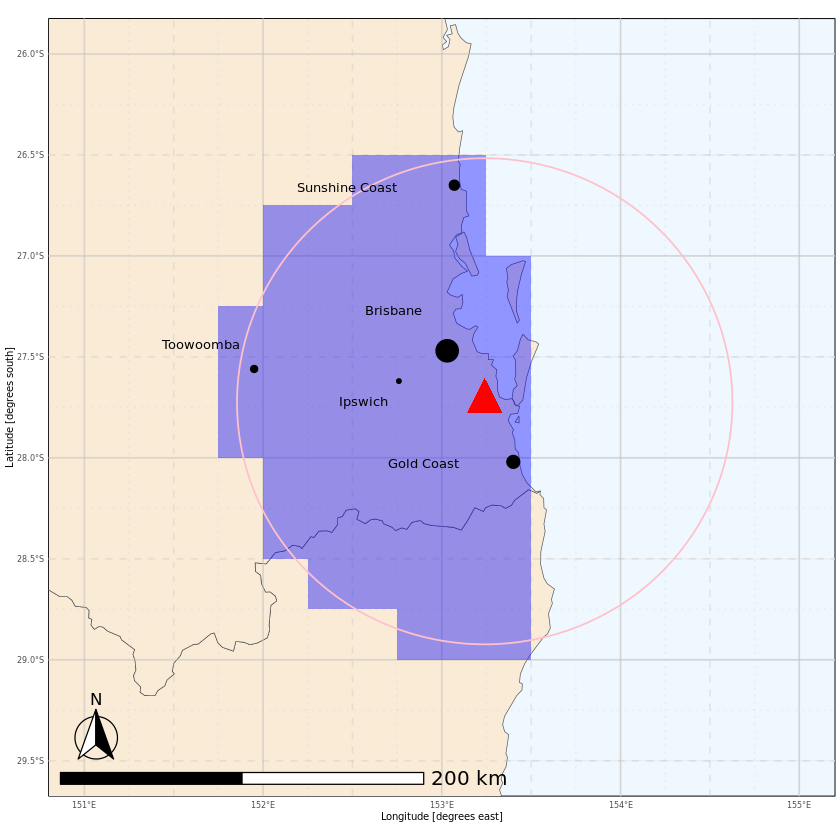

In [2]:
# get all the states data
sf_oz <- ozmap_data("states")

# set up a palet for plotting the background
pal <- paletteer::paletteer_d(palette = "ochRe::namatjira_qual")
opal <- colorRampPalette(pal)
nmjr <- opal(nrow(sf_oz))

# basic plot with coordinates and coloured by states
p <- ggplot(sf_oz) + 
  geom_sf(fill = "antiquewhite") + 
  coord_sf() + 
  scale_fill_manual(values = nmjr) +
  theme_minimal(base_size = 6) + 
  theme(legend.position = "none", 
        panel.background = element_rect(fill = "aliceblue")) + 
  xlim(151, 155) + 
  ylim(-29.5, -26) 

# plotting radar range
# getting radar location as australian albers (i.e. meters)
aust_albers_radar <- st_as_sf(tibble(long = 153.24, lat = -27.72), 
                              coords = c("long", "lat"), crs = 4326) %>% 
  st_transform("EPSG:3577") %>%
  st_coordinates

# getting the radius of a certain range
range <- 135 # km
circle_x <- aust_albers_radar[1, "X"] + (range * 1000 * cos(0:360 * pi / 180))
circle_y <- aust_albers_radar[1, "Y"] + (range * 1000 * sin(0:360 * pi / 180))

# coordinates in m back into degrees
circle_sf <- st_as_sf(tibble(x = circle_x, y = circle_y), coords = c("x", "y"), 
                      crs = "EPSG:3577") %>% 
  st_transform(4326)

# degrees into a tibble for plotting 
circle_tibble <- circle_sf %>% 
  as_tibble %>% mutate(lat = st_coordinates(geometry)[, 2],
                       long = st_coordinates(geometry)[, 1])

# triangle for the radar marker
radar_lat <- -27.72
radar_lon <- 153.24
side_length <- 0.2
x_adj <- side_length / 2
y_adj <- side_length / (2 * sqrt(3))
radar_tri_x <- c(radar_lon - x_adj, radar_lon + x_adj, radar_lon)
radar_tri_y <- c(radar_lat - y_adj, radar_lat - y_adj, radar_lat + (2 * y_adj))
  
# study area
x_study <- c(151.75, 152, 152, 152.25, 152.25, 152.75, 152.75, 153.5, 153.5, 153.25, 153.25, 152.5, 152.5, 152, 152, 151.75, 151.75)
y_study <- c(-28, -28, -28.5, -28.5, -28.75, -28.75, -29, -29, -27, -27, -26.5, -26.5, -26.75, -26.75, -27.25, -27.25, -28)

# city locations and populations
# https://abs.gov.au/census/find-census-data/quickstats/2021/317
city_locations <- tribble(~x, ~y, ~pop,
        153.03, -27.47, 2526238, # Brisbane
        153.40, -28.02, 640778, # Gold Coast
        153.07, -26.65, 342541, # Sunshine Coast
        152.76, -27.62, 115913, # Ipswich
        151.95, -27.56, 162059 # Toowoomba
        )

text_size <- 2.75
p +
  # grid lines overthe map but under the text 
  # major lines
  geom_vline(xintercept=seq(151, 155, by=1), color = "grey", alpha = 0.5) +
  geom_hline(yintercept=seq(-29, -26, by=1), color = "grey", alpha = 0.5) +
  # minor lines
  geom_vline(xintercept=seq(151.5, 154.5, by=1), color = "grey", alpha = 0.3, 
             linetype = "dashed") +
  geom_hline(yintercept=seq(-29.5, -26.5, by=1), color = "grey", alpha = 0.3, 
             linetype = "dashed") +
  # grid level
  geom_vline(xintercept=seq(151.25, 154.75, by=0.5), color = "grey", alpha = 0.2, 
             linetype = "dotted") +
  geom_hline(yintercept=seq(-29.25, -26.25, by=0.5), color = "grey", alpha = 0.2, 
             linetype = "dotted") +
  # study area
  annotate("polygon", x = x_study, y = y_study, fill = "blue", alpha = 0.4) +
  # radar range 
  geom_polygon(aes(x = long, y = lat), color = "pink", fill = NA, 
               data = circle_tibble) +
  # key cities and locations
  # brisbane
  geom_point(aes(x = x, y = y, size = pop), color = "black", data = city_locations) +
  annotate("text", x = 153.03 - 0.3, y = -27.47 + 0.2, label = "Brisbane", 
           size = text_size) +
  # mount stapylton weather radar
  annotate("polygon", x = radar_tri_x, y = radar_tri_y, fill = "red", size = 3) +
  # gold coast
  #annotate("point", x = 153.40, y = -28.02, color = "black", size = 3) +
  annotate("text", x = 153.40 - 0.5, y = -28.02 - 0.01, label = "Gold Coast", 
           size = text_size) +
  # sunshine coast
  #annotate("point", x = 153.07, y = -26.65, color = "black", size = 3) +
  annotate("text", x = 153.07 - 0.6, y = -26.65 - 0.01, label = "Sunshine Coast",
           size = text_size) +
  # ipswich
  #annotate("point", x = 152.76, y = -27.62, color = "black", size = 1) +
  annotate("text", x = 152.76 - 0.2, y = -27.62 - 0.1, label = "Ipswich",
           size = text_size) +
  # toowoomba
  #annotate("point", x = 151.95, y = -27.56, color = "black", size = 1) +
  annotate("text", x = 151.95 - 0.3, y = -27.56 + 0.12, label = "Toowoomba",
           size = text_size) +
  # labels
  xlab("Longitude [degrees east]") + 
  ylab("Latitude [degrees south]") +
  annotation_scale(location = "bl", width_hint = 0.5, text_cex = 1.00) +
  annotation_north_arrow(location = "bl", which_north = "true", 
                         pad_y = unit(0.25, "in"),
                         style = north_arrow_fancy_orienteering
                         )

options(repr.plot.width = 7, repr.plot.height = 7)

Note that this figure was generated with `quarto` which handled the sizing of the figure which we have endeavoured to approximate here.